# **Walmart Recruiting - Store Sales Forecasting**

## **Import libraries:**

In [0]:
# importing all the libraries needed 
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
sns.set_style("whitegrid")
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error

#For date time functions
from datetime import datetime
from datetime import timedelta
import math

# Importing the most popular regression libraries.
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, ridge_regression, Lasso, SGDRegressor, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
from google.colab import files
uploaded = files.upload()

Saving walmart-recruiting-store-sales-forecasting.zip to walmart-recruiting-store-sales-forecasting.zip


In [3]:
!apt install unzip
!unzip  walmart-recruiting-store-sales-forecasting.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: train.csv               
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: features.csv            
  inflating: stores.csv              
  inflating: Weekly Sales Prediction.csv  


## **Load Dataset:**

In [0]:
#Loading the data from csv files.
train=pd.read_csv('train.csv')
features=pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')

In [0]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [0]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [0]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


## **Data-check:**

In [0]:
#Check for null values in train
train.isnull().any()

Store           False
Dept            False
Date            False
Weekly_Sales    False
IsHoliday       False
dtype: bool

In [0]:
#Check for null values in features.
features.isnull().any()

Store           False
Date            False
Temperature     False
Fuel_Price      False
MarkDown1        True
MarkDown2        True
MarkDown3        True
MarkDown4        True
MarkDown5        True
CPI              True
Unemployment     True
IsHoliday       False
dtype: bool

In [0]:
#Check for null values in stores.
stores.isnull().any()

Store    False
Type     False
Size     False
dtype: bool

There are null values present in below columns.
- MarkDown1, MarkDown2, MarkDown3, MarkDown4, MarkDown5, CPI and Unemployment


In [0]:
#Count of null values present in respective columns of features.
features.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [0]:
#Original shape of train, features and stores data.
print('train: ', train.shape)
print('features: ', features.shape)
print('stores ', stores.shape)

train:  (421570, 5)
features:  (8190, 12)
stores  (45, 3)


## **Merging datasets:**

In [3]:
#Merging the three csv files using inner join.
data = train.merge(features, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')
print(data.shape)

(421570, 17)


In [0]:
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315


In [4]:
#Removing additional IsHoliday column (IsHoliday_y) and renaming original IsHoliday_x column to IsHoliday.
data = data.drop(['IsHoliday_y'], axis=1)
data = data.rename(columns={'IsHoliday_x':'IsHoliday'})
data.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size'],
      dtype='object')

In [0]:
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [0]:
data.shape

(421570, 16)

## **Data Preprocessing:**

##### NaN for markdown means that there was no markdown event for that date. So we can replace that with 0 indicating no mark down

In [5]:
# First we check what happens when we replace NaN's with 0.
data.fillna(0).head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315


In [0]:
data.isnull().head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,False,False,False,False,False,False,False,True,True,True,True,True,False,False,False,False
1,False,False,False,False,False,False,False,True,True,True,True,True,False,False,False,False
2,False,False,False,False,False,False,False,True,True,True,True,True,False,False,False,False
3,False,False,False,False,False,False,False,True,True,True,True,True,False,False,False,False
4,False,False,False,False,False,False,False,True,True,True,True,True,False,False,False,False


In [0]:
# Removing rows with null values in all columns
data.dropna(axis=0, how="all", inplace=True)
# Removing all rows with null values in all rows
data.dropna(axis=1, how="all", inplace=True)

In [0]:
# Fill missing values with 0
data=data.fillna(0)

In [0]:
data.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64

In [0]:
data.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.183519,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,60980.583328
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


In [0]:
print('Final Data Shape: ', data.shape)

Final Data Shape:  (421570, 16)


In [0]:
# Taking Mean of Temparature, Weekly Sales and Unemployment columns and forming additional columns.
temp_mean = data.Temperature.fillna(data['Temperature'].mean())
unemployment_mean = data.Unemployment.fillna(data['Unemployment'].mean())
weekly_sales_mean = data.Weekly_Sales.fillna(data['Weekly_Sales'].mean())

data['Weekly Sales Mean'] = weekly_sales_mean
data['Unemployment Mean'] = unemployment_mean
data['Temperature Mean']  = temp_mean

In [0]:
data.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Weekly Sales Mean,Unemployment Mean,Temperature Mean
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,136727.915739,15981.258123,7.960289,60.090059
std,12.785297,30.492054,22711.183519,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,60980.583328,22711.183519,1.863296,18.447931
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000,-4988.940000,3.879000,-2.060000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000,2079.650000,6.891000,46.680000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,140167.000000,7612.030000,7.866000,62.090000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,202505.000000,20205.852500,8.572000,74.280000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000,693099.360000,14.313000,100.140000


In [9]:
# Remove negative values as sales cannot be negative values.
data= data[data['Weekly_Sales'] >= 0]
data.shape

(420285, 19)

## **Exploratory Data Analysis:**

#### 1. Weekly Sales by Department:

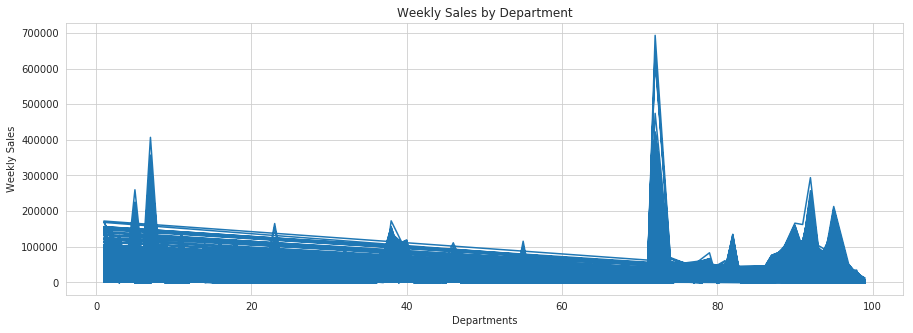

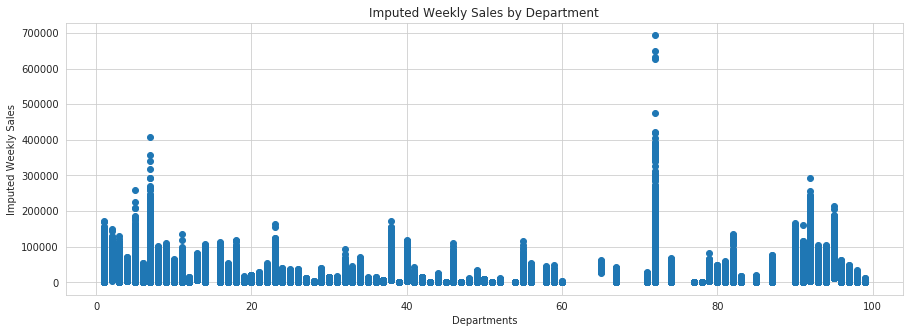

In [0]:
#Plot of Weekly Sales and Department.
x = data['Dept']
y = data['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')
plt.plot(x,y)
plt.show()

#Plot of Mean Weekly Sales and Department.
x = data['Dept']
y = data['Weekly Sales Mean']
plt.figure(figsize=(15,5))
plt.title('Imputed Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Imputed Weekly Sales')
plt.scatter(x,y)
plt.show()

 - Observation: Most of the Departments have weekly sales below 200000.

#### 2. Weekly Sales by Stores:

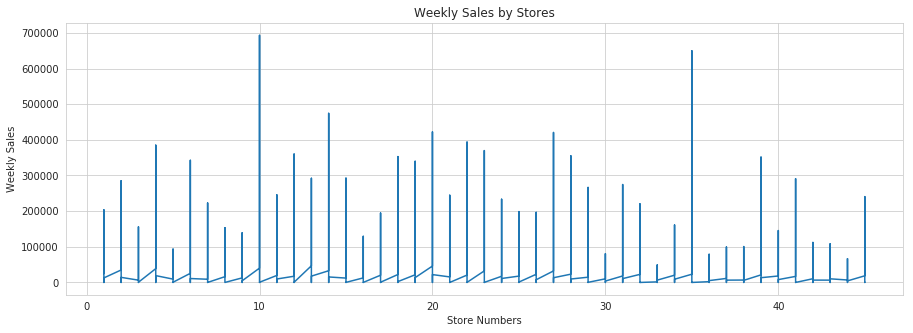

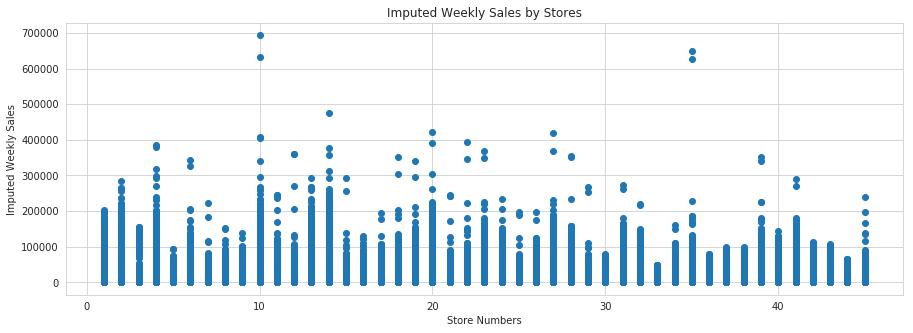

In [0]:
#Plot of Weekly Sales and Stores.
x = data['Store']
y = data['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Stores')
plt.xlabel('Store Numbers')
plt.ylabel('Weekly Sales')
plt.plot(x,y)
plt.show()

#Plot of Mean Weekly Sales and Stores.
x = data['Store']
y = data['Weekly Sales Mean']
plt.figure(figsize=(15,5))
plt.title('Imputed Weekly Sales by Stores')
plt.xlabel('Store Numbers')
plt.ylabel('Imputed Weekly Sales')
plt.scatter(x,y)
plt.show()

 - Observation: Weekly sales is highest for Store number 10 and lowest for Store number 44.

#### 3. Weekly Sales by Year, Month and Week:

In [0]:
# First we need to get Year, Month and Week columns from Date column.
data.Date = pd.to_datetime(data.Date)
data['Year']  = data.Date.dt.year
data['Month'] = data.Date.dt.month
data['Week']  = data.Date.dt.week

data.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Weekly Sales Mean,Unemployment Mean,Temperature Mean,Year,Month,Week
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,24924.50,8.106,42.31,2010,2,5
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,50605.27,8.106,42.31,2010,2,5


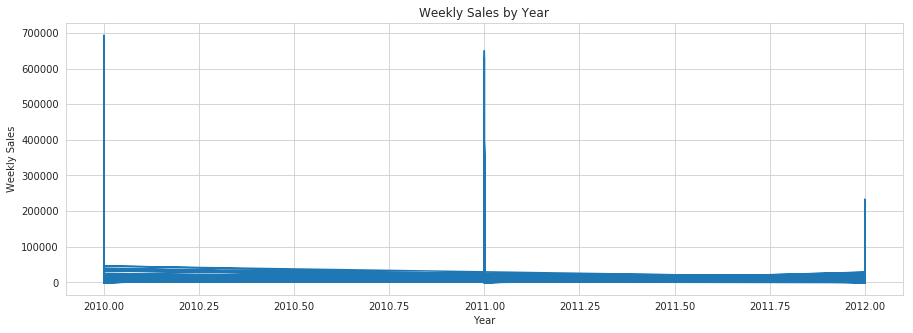

In [0]:
#Plot of Weekly Sales and Year.
x = data['Year']
y = data['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Year')
plt.xlabel('Year')
plt.ylabel('Weekly Sales')
plt.plot(x,y)
plt.show()

 - Observation: Year 2011 had the highest weekly sales.

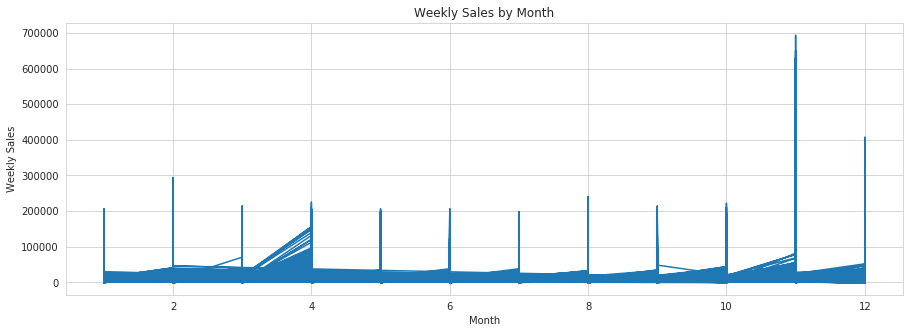

In [0]:
#Plot of Weekly Sales and Month.
x = data['Month']
y = data['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Month')
plt.xlabel('Month')
plt.ylabel('Weekly Sales')
plt.plot(x,y)
plt.show()

 - Observation: November month witnessed the maximum weekly sales.

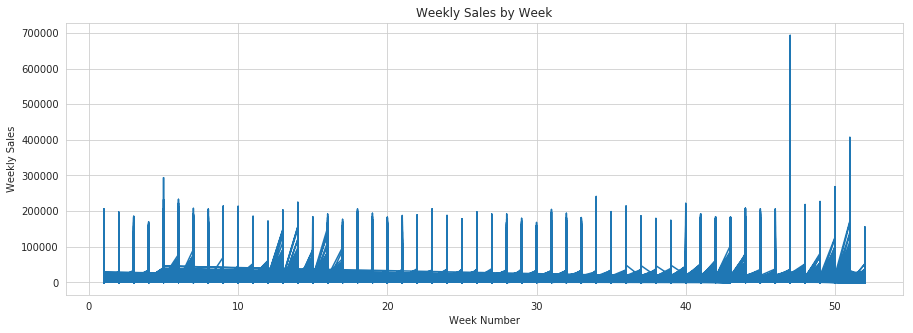

In [0]:
#Plot of Weekly Sales and Week.
x = data['Week']
y = data['Weekly_Sales']
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Week')
plt.xlabel('Week Number')
plt.ylabel('Weekly Sales')
plt.plot(x,y)
plt.show()

 - Observation: Week 47 of November month had the highest weekly sales.

#### 4. Store Size by Store Type:

In [0]:
print("the shape of stores data set is", stores.shape)
print('='*50)
print("the unique value of store is", stores['Store'].unique())
print('='*110)
print("the unique value of Type is", stores['Type'].unique())

the shape of stores data set is (45, 3)
the unique value of store is [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
the unique value of Type is ['A' 'B' 'C']


In [0]:
sorted_type = stores.groupby('Type')
print(sorted_type.describe()['Size'].round(2))

      count       mean       std  ...       50%       75%       max
Type                              ...                              
A      22.0  177247.73  49392.62  ...  202406.0  203819.0  219622.0
B      17.0  101190.71  32371.14  ...  114533.0  123737.0  140167.0
C       6.0   40541.67   1304.15  ...   39910.0   40774.0   42988.0

[3 rows x 8 columns]


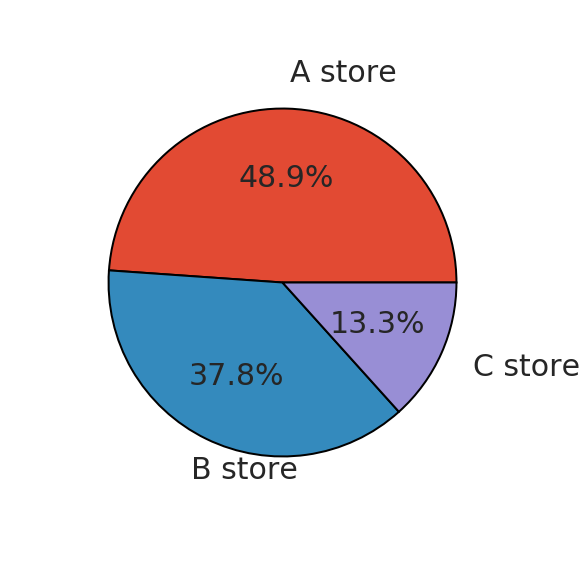

In [0]:
#Make Pie chart for Stores including Weekly Sales.
plt.style.use('ggplot')
labels=['A store','B store','C store']
sizes=sorted_type.describe()['Size'].round(1)
sizes=[(22/(17+6+22))*100,(17/(17+6+22))*100,(6/(17+6+22))*100] # convert to the proportion

fig, axes = plt.subplots(1,1, figsize=(10,10))

wprops={'edgecolor':'black',
      'linewidth':2}

tprops = {'fontsize':30}

axes.pie(sizes,
        labels=labels,
        explode=(0.0,0,0),
        autopct='%1.1f%%',
        pctdistance=0.6,
        labeldistance=1.2,
        wedgeprops=wprops,
        textprops=tprops,
        radius=0.8,
        center=(0.5,0.5))
plt.show()

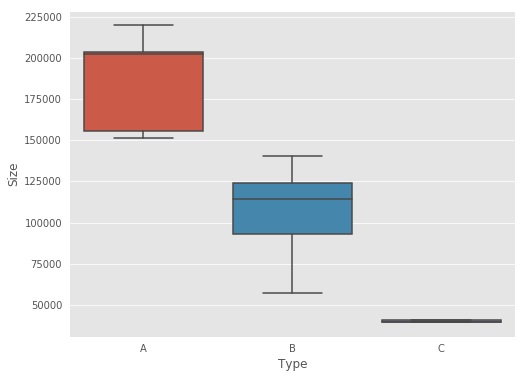

In [0]:
#Box Plot of Store Type and Store Size.
type_size = pd.concat([stores['Type'], stores['Size']], axis=1)
plt.figure(figsize=(8,6))
fig = sns.boxplot(x='Type', y='Size', data=type_size, showfliers=False)

#### 5. Train-Stores table analysis:

In [0]:
train_stores = train.merge(stores, on='Store', how='inner')
train_stores.head()

,Date,Dept,IsHoliday,Store,Weekly_Sales,train/test,Type,Size
0,2010-02-05,1,False,1,24924.50,Train,A,151315
1,2010-02-12,1,True,1,46039.49,Train,A,151315
2,2010-02-19,1,False,1,41595.55,Train,A,151315
3,2010-02-26,1,False,1,19403.54,Train,A,151315
4,2010-03-05,1,False,1,21827.90,Train,A,151315


In [0]:
# Form Date, Year, Month, Week, Day and No. of days.
train_stores['Date'] = pd.to_datetime(train_stores['Date'])
train_stores['Year'] = train_stores['Date'].dt.year
train_stores['Month']= train_stores['Date'].dt.month
train_stores['Week'] = train_stores['Date'].dt.week
train_stores['Day']  = train_stores['Date'].dt.day
train_stores['No. of days'] = (train_stores['Date'].dt.date - train_stores['Date'].dt.date.min()).apply(lambda x:x.days)

In [0]:
train_stores.head()

,Date,Dept,IsHoliday,Store,Weekly_Sales,train/test,Type,Size,Year,Month,Week,Day,No. of days
0,2010-02-05,1,False,1,24924.50,Train,A,151315,2010,2,5,5,0
1,2010-02-12,1,True,1,46039.49,Train,A,151315,2010,2,6,12,7
2,2010-02-19,1,False,1,41595.55,Train,A,151315,2010,2,7,19,14
3,2010-02-26,1,False,1,19403.54,Train,A,151315,2010,2,8,26,21
4,2010-03-05,1,False,1,21827.90,Train,A,151315,2010,3,9,5,28


In [0]:
Year        = pd.Series(train_stores['Year'].unique())
Week        = pd.Series(train_stores['Week'].unique())
Month       = pd.Series(train_stores['Month'].unique())
Day         = pd.Series(train_stores['Day'].unique())
No_of_days  = pd.Series(train_stores['No. of days'].unique())

#### 6. Weekly Sales for Store Type:

In [0]:
# There are negative values present in Weekly sales which are absurd because sales cannot be negative.
train_stores= train_stores[train_stores['Weekly_Sales'] > 0]

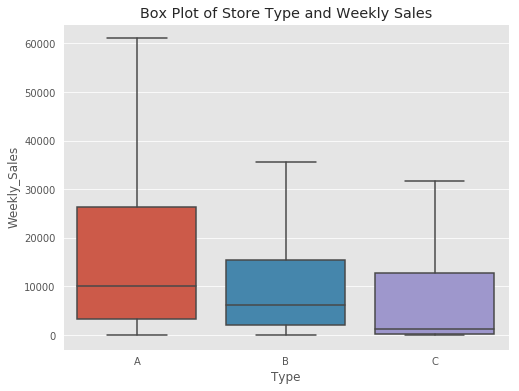

In [0]:
#Plot of Store Type and Weekly Sales
type_sales = pd.concat([train_stores['Type'], train_stores['Weekly_Sales']], axis=1)
plt.figure(figsize=(8,6))
plt.title('Box Plot of Store Type and Weekly Sales')
fig = sns.boxplot(x='Type', y='Weekly_Sales', data=type_sales, showfliers=False)

 - Observation: Type A stores have their medians higher than any other medians in other store types, so the weekly sales for store type A is more than other store types.

#### 7. Weekly Sales for Store Size:

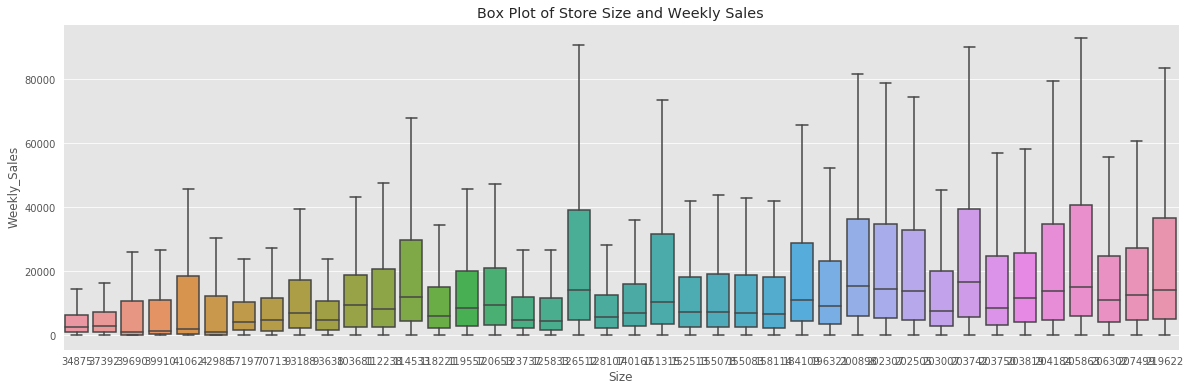

In [0]:
#Plot of Store Size and Weekly Sales.
size_sales = pd.concat([train_stores['Size'], train_stores['Weekly_Sales']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Store Size and Weekly Sales')
fig = sns.boxplot(x='Size', y='Weekly_Sales', data=size_sales, showfliers=False)

#### 8. Weekly Sales by Store Number and Store Type:

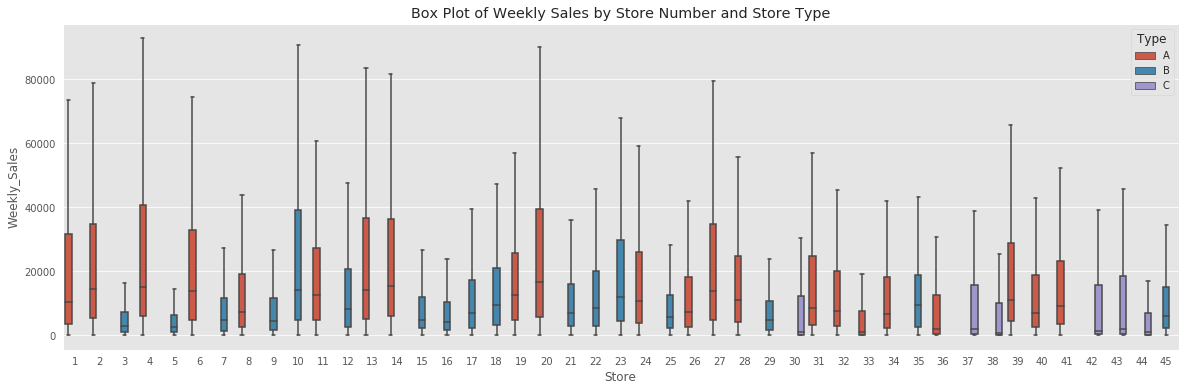

In [0]:
#Plot of Weekly Sales by Store Number and Store Type.
data_8 = pd.concat([train_stores['Store'], train_stores['Weekly_Sales'], train_stores['Type']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Store Number and Store Type')
fig = sns.boxplot(x='Store', y='Weekly_Sales', data=data_8, showfliers=False, hue='Type')

 - Observation: We can observe that store number 4 followed by 20 have the highest sales, so are their median sales values.

#### 9. Weekly Sales by Store Number and Holiday:

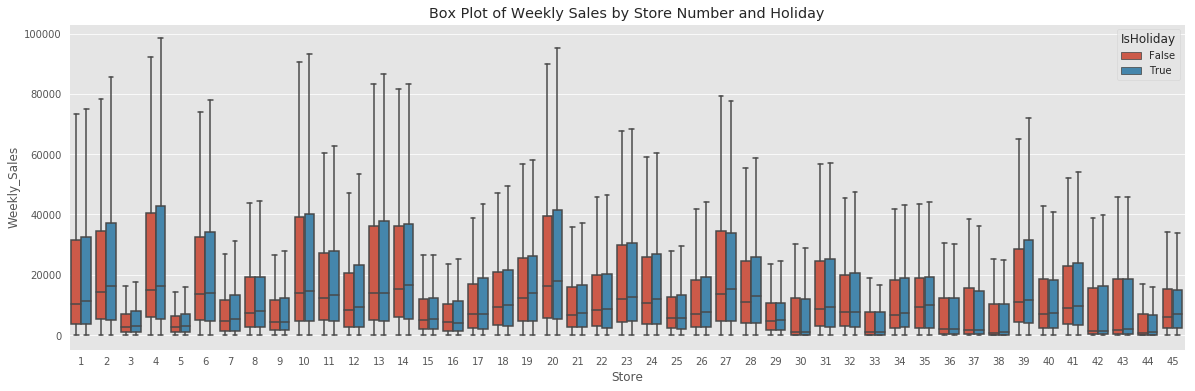

In [0]:
#Plot of Weekly Sales by Store Number and Holiday.
data_9 = pd.concat([train_stores['Store'], train_stores['Weekly_Sales'], train_stores['IsHoliday']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Store Number and Holiday')
fig = sns.boxplot(x='Store', y='Weekly_Sales', data=data_9, showfliers=False, hue='IsHoliday')

 - Observation: We can't interpret the reation here, but we can observe that sales are more on holidays.

#### 10. Weekly Sales by Department and Store Type:

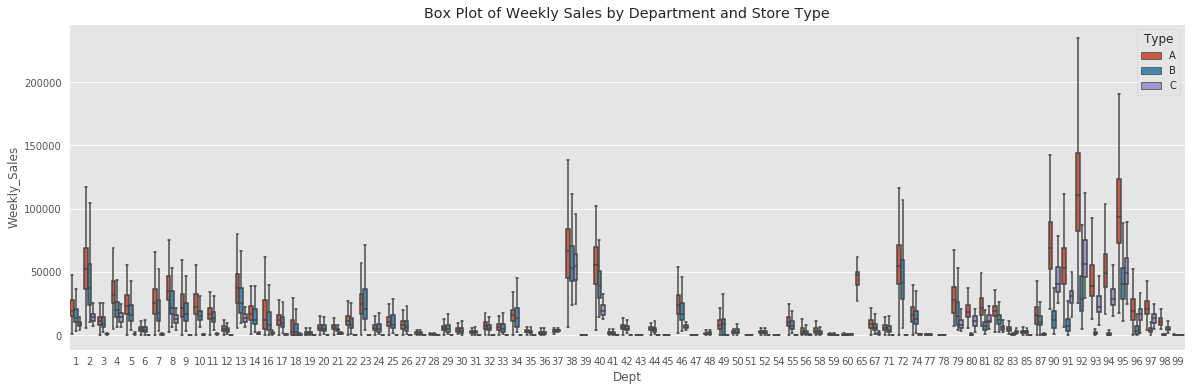

In [0]:
data_10 = pd.concat([train_stores['Dept'], train_stores['Weekly_Sales'], train_stores['Type']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Department and Store Type')
fig = sns.boxplot(x='Dept', y='Weekly_Sales', data=data_10, showfliers=False, hue='Type')

 - Observation: Here we can infer that weekly sales for store type A is more than any other store types.

#### 11. Weekly Sales by Department and Holiday:

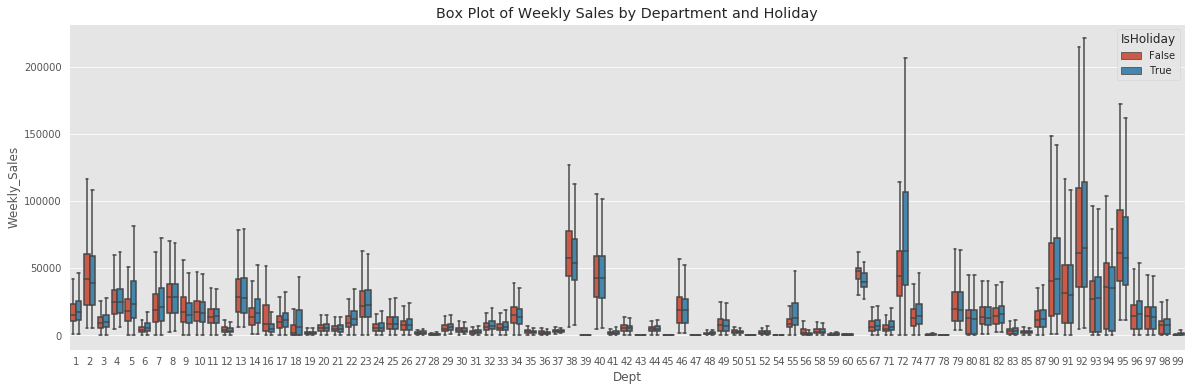

In [0]:
data_11= pd.concat([train_stores['Dept'], train_stores['Weekly_Sales'], train_stores['IsHoliday']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Department and Holiday')
fig = sns.boxplot(x='Dept', y='Weekly_Sales', data=data_11, showfliers=False, hue="IsHoliday")

Observations:
- Department number 92 has highest sales that too happened on holiday.
- There is no explicit relation between Department and Weekly Sales.

#### 12. Weekly Sales on Holidays and Non-Holidays:

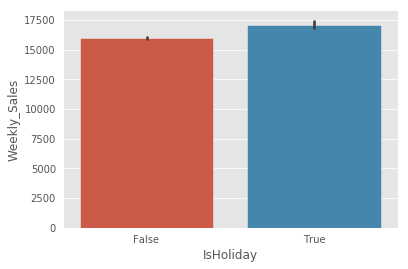

In [0]:
holiday = train_stores['Weekly_Sales'].loc[train_stores['IsHoliday']== True] # Weekly Sales in Holidays
non_holiday = train_stores['Weekly_Sales'].loc[train_stores['IsHoliday']== False] #Weekly Sales in Non-holidays.

sns.barplot(x='IsHoliday', y='Weekly_Sales', data=train_stores)

 - Observation: We see the sales are higher on holidays than on non holidays.

#### 13. Monthwise Weekly Sales:

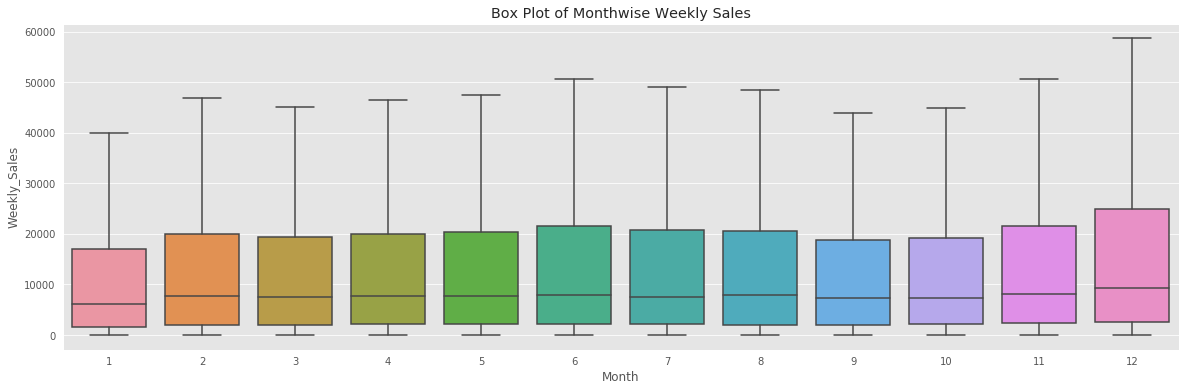

In [0]:
data_13 = pd.concat([train_stores['Month'], train_stores['Weekly_Sales']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Monthwise Weekly Sales')
fig = sns.boxplot(x='Month', y='Weekly_Sales', data=data_13, showfliers=False)

 - Observation: December month had maximum sales.

#### 14. Weekly Sales by Month and Holiday:

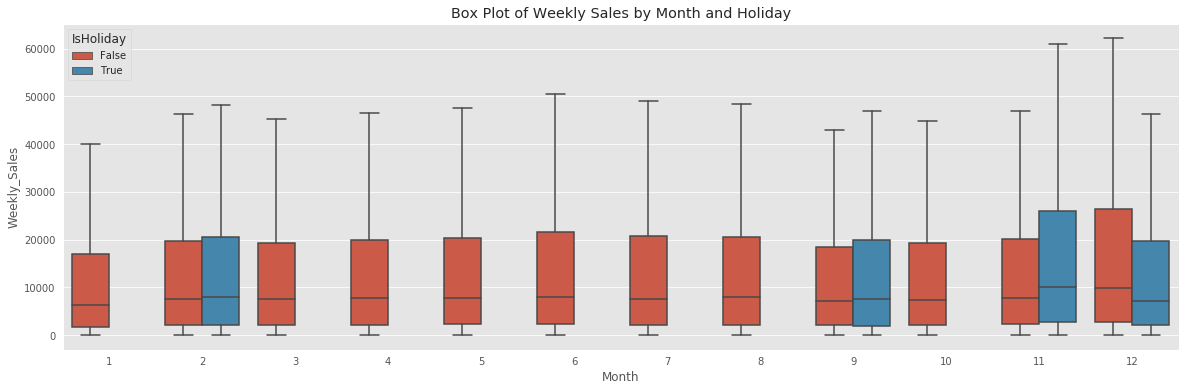

In [0]:
data_14 = pd.concat([train_stores['Month'], train_stores['Weekly_Sales'], train_stores['IsHoliday']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Month and Holiday')
fig = sns.boxplot(x='Month', y='Weekly_Sales', data=data_14, showfliers=False, hue='IsHoliday')

 - Observation: Non holidays have sales in each of the monhs and in December the sales, which is the highest among all sales, is even more than sales in holidays.

#### 15. Weekly Sales by Month and Store Type:

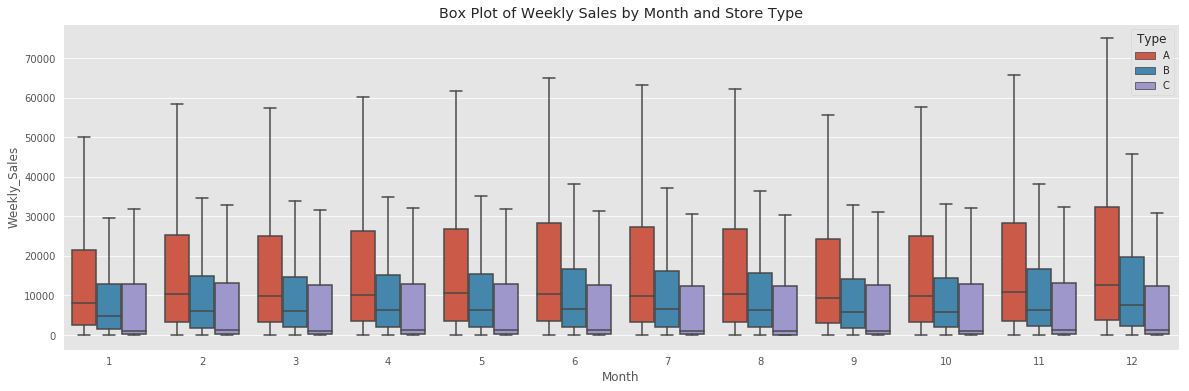

In [0]:
data_15 = pd.concat([train_stores['Month'], train_stores['Weekly_Sales'], train_stores['Type']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Month and Store Type')
fig = sns.boxplot(x='Month', y='Weekly_Sales', data=data_15, showfliers=False, hue='Type')

 - Observation: In every month Store Type A has the maximum sales.

#### 16. Weekly Sales by Year:

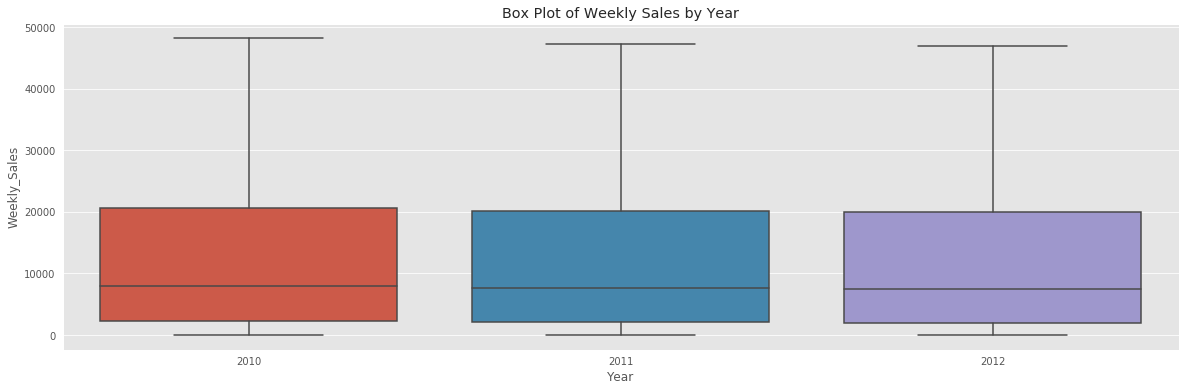

In [0]:
data_16 = pd.concat([train_stores['Year'], train_stores['Weekly_Sales']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Year')
fig = sns.boxplot(x='Year', y='Weekly_Sales', data=data_16, showfliers=False)

 - Observation: There seems no clear distinction from this plot.

#### 17. Weekly Sales by Week:

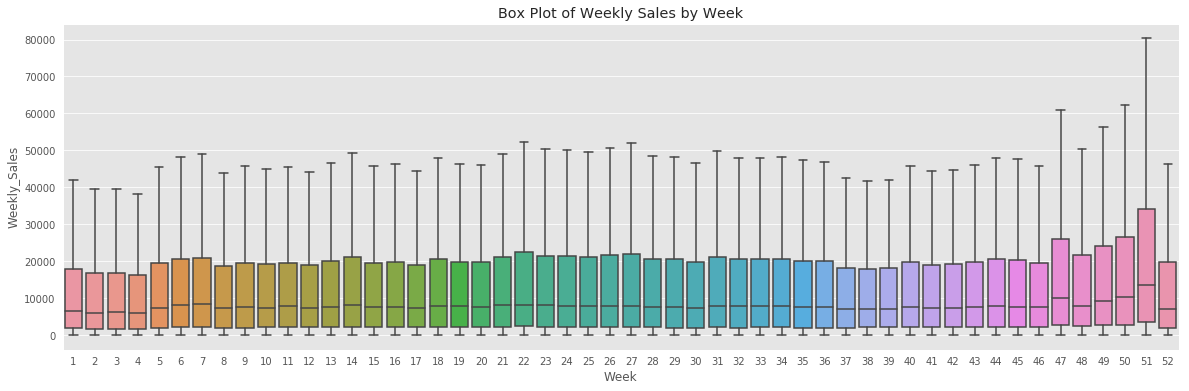

In [0]:
data_17 = pd.concat([train_stores['Week'], train_stores['Weekly_Sales']], axis=1)
plt.figure(figsize=(20,6))
plt.title('Box Plot of Weekly Sales by Week')
fig = sns.boxplot(x='Week', y='Weekly_Sales', data=data_17, showfliers=False)

 - Observation: The 51st week i.e. third week of December has the highest sales.

#### 18. Histogram of Weekly Sales:

Minimum sales:  0.01


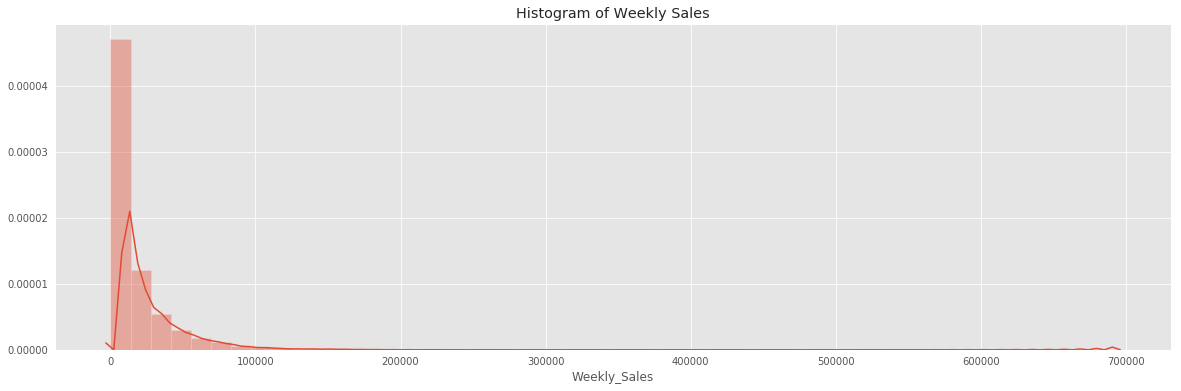

In [0]:
plt.figure(figsize=(20,6))
plt.title('Histogram of Weekly Sales')
fig = sns.distplot(train_stores['Weekly_Sales'].dropna()) #Taking only valid weekly sales values.
print('Minimum sales:', train_stores['Weekly_Sales'].min())

 - Observation: About all sales have happened below 100000. Maximum sales are done at sales value of 1000.

#### 19. Probability Plot of Weekly Sales:

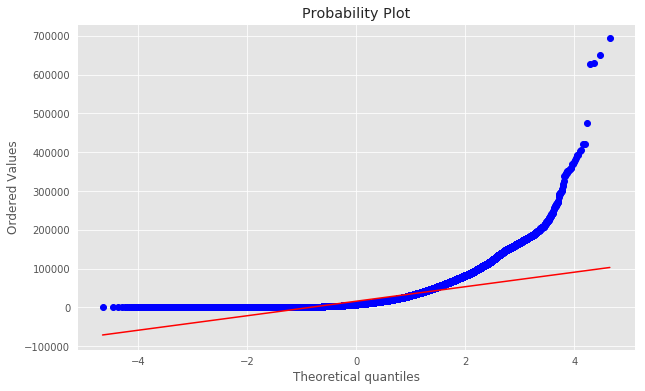

In [0]:
plt.figure(figsize=(10,6))
fig = stats.probplot(train_stores['Weekly_Sales'], plot=plt)

#### 20. Distributions of MarkDown 1, MarkDown 2, MarkDown 3, MarkDown 4, MarkDown 5:

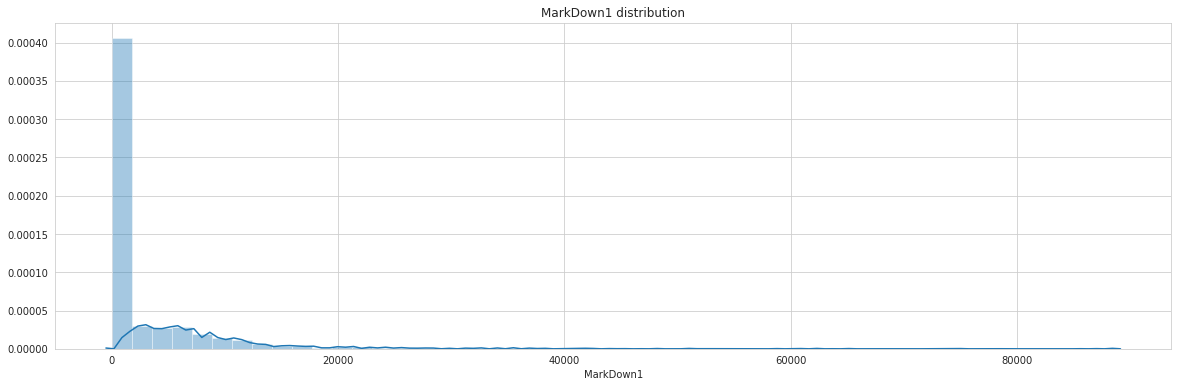

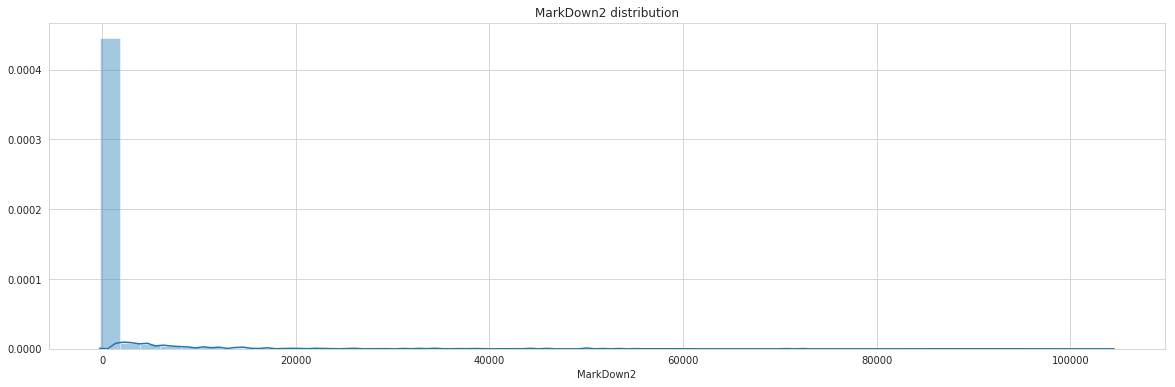

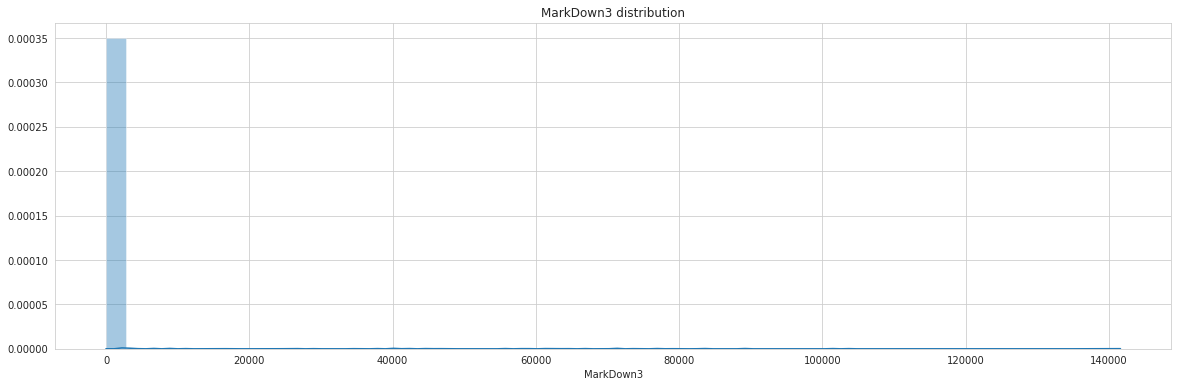

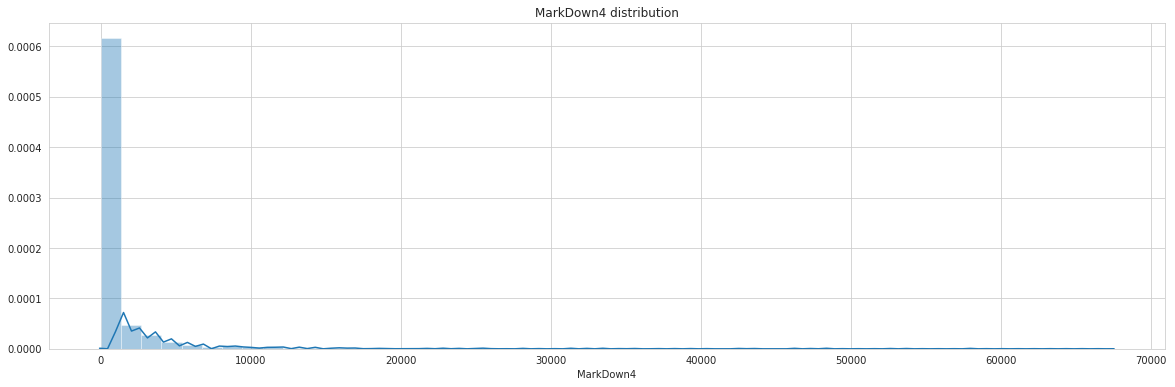

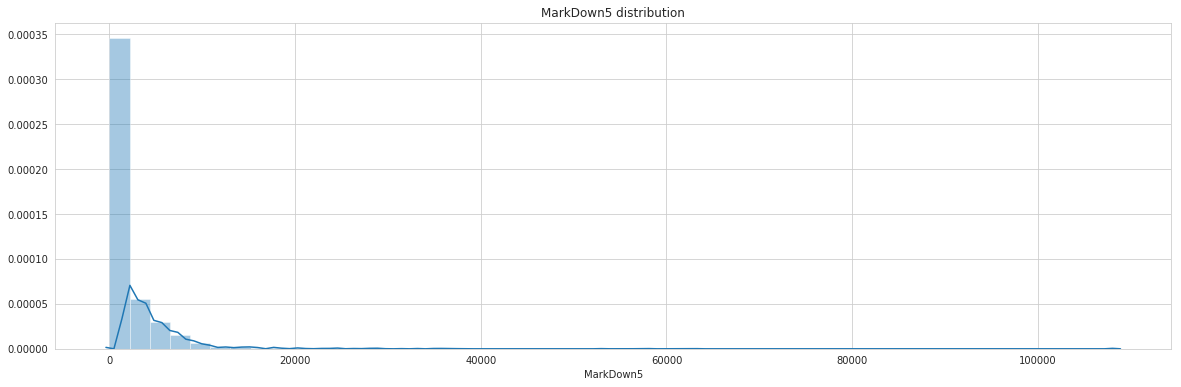

In [0]:
# Histograms of MarkDowns.
def markdowns(data, column):
  plt.figure(figsize=(20,6))
  sns.distplot(data[column], kde=True)
  plt.title(str(column)+' distribution')
  plt.xlabel(column)
  
markdowns(data, 'MarkDown1')
markdowns(data, 'MarkDown2')
markdowns(data, 'MarkDown3')
markdowns(data, 'MarkDown4')
markdowns(data, 'MarkDown5')

In [0]:
# Scatter plots of MarkDowns.
def scatter(data, column):
    plt.figure(figsize=(20,6))
    plt.scatter(data[column] , data['Weekly_Sales'])
    plt.title('Weekly sales by '+str(column))
    plt.ylabel('Weekly_Sales')
    plt.xlabel(column)
    

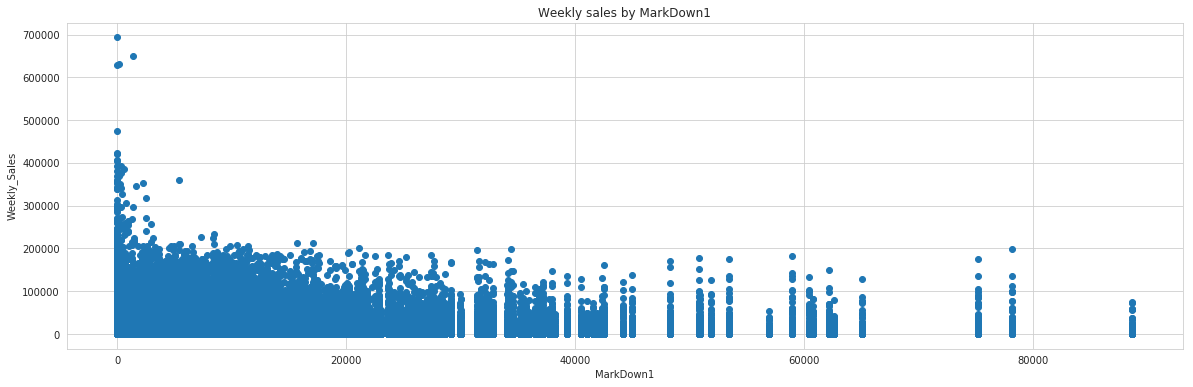

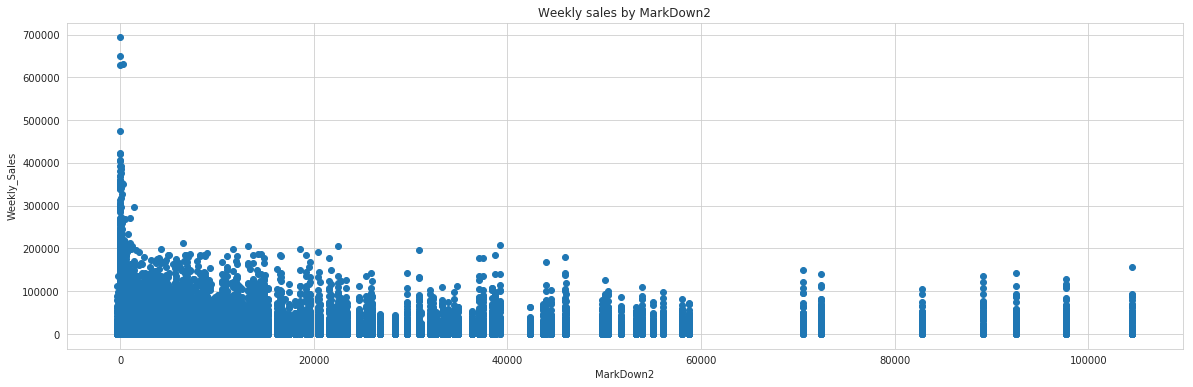

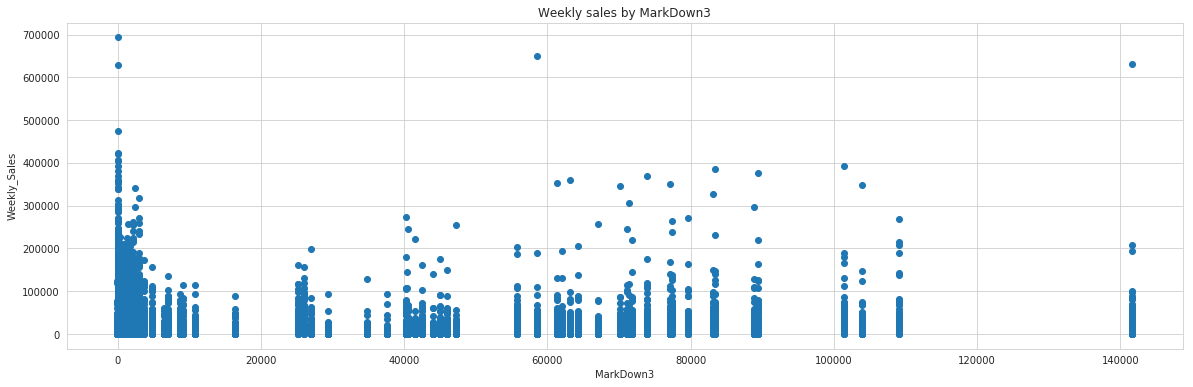

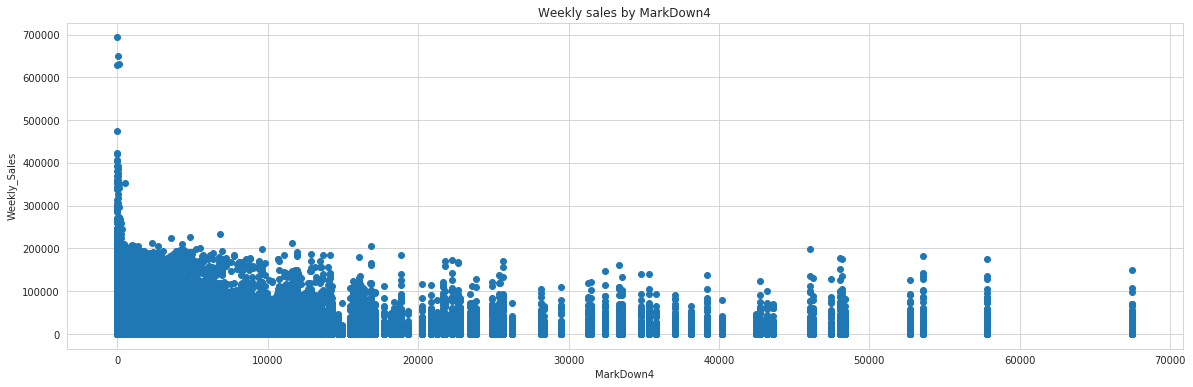

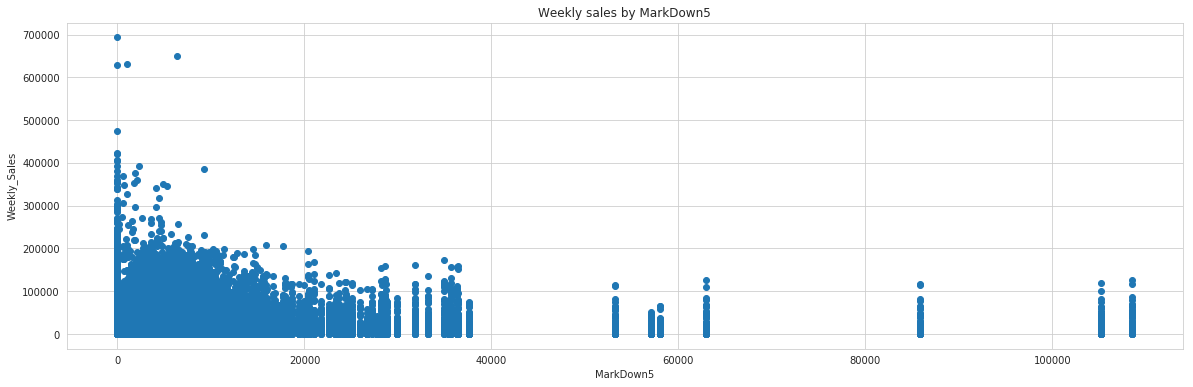

In [0]:
scatter(data, 'MarkDown1')
scatter(data, 'MarkDown2')
scatter(data, 'MarkDown3')
scatter(data, 'MarkDown4')
scatter(data, 'MarkDown5')

  - Observation: Most of the Markdowns have been given for Weekly sales of less than 200000

#### 21. Fuel, Temparature and CPI effects:

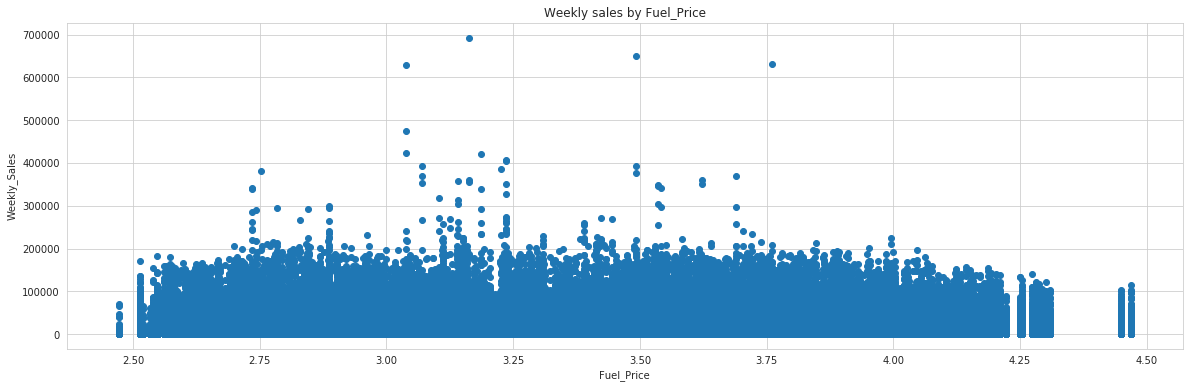

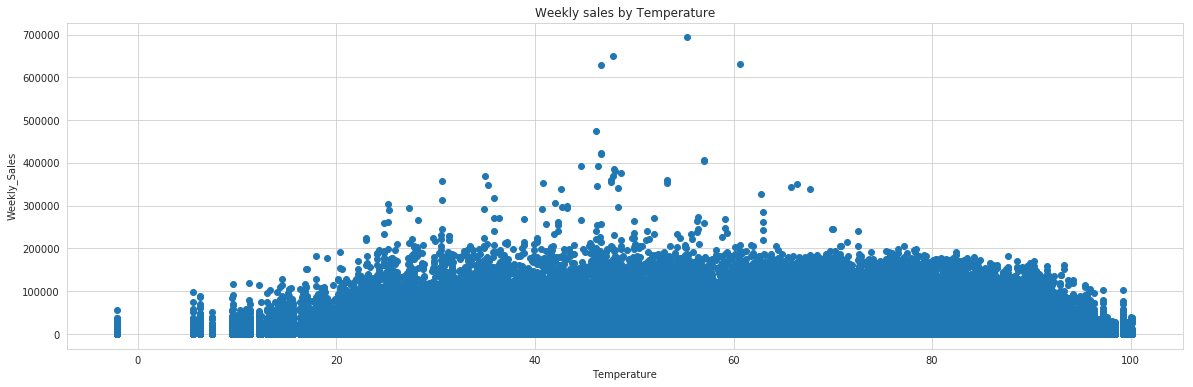

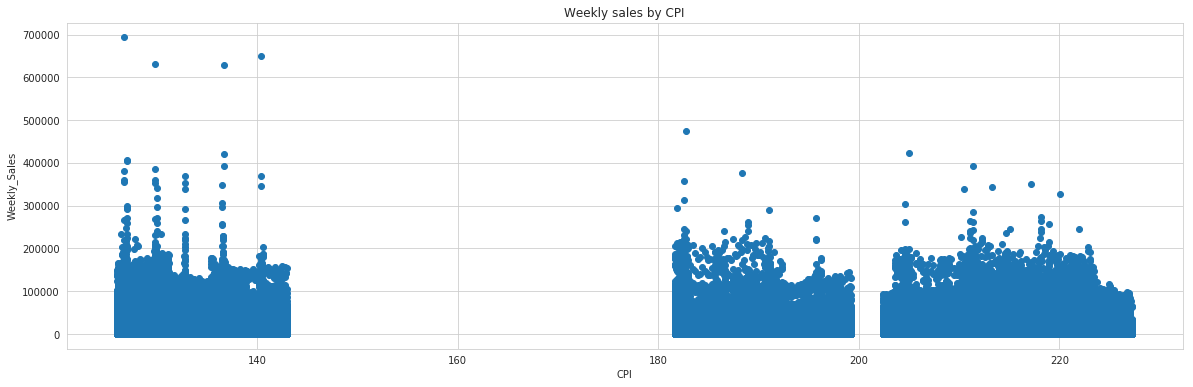

In [0]:
scatter(data, 'Fuel_Price') # Fuel
scatter(data, 'Temperature') #Temparature
scatter(data, 'CPI') #CPI

- Observations:
  1. Most of the Fuel price value lies in range of 2.5 to 4 for weekly sales of less than 200000.
  2. Sales of less than 200000 happened for average temparature range of 30 to 80.
  3. No weekly sales for CPI range of 145 to 180. CPI range (200 - 230) is more when the weekly sales is less than 200000.
  

### Compute Correlation Matrix:

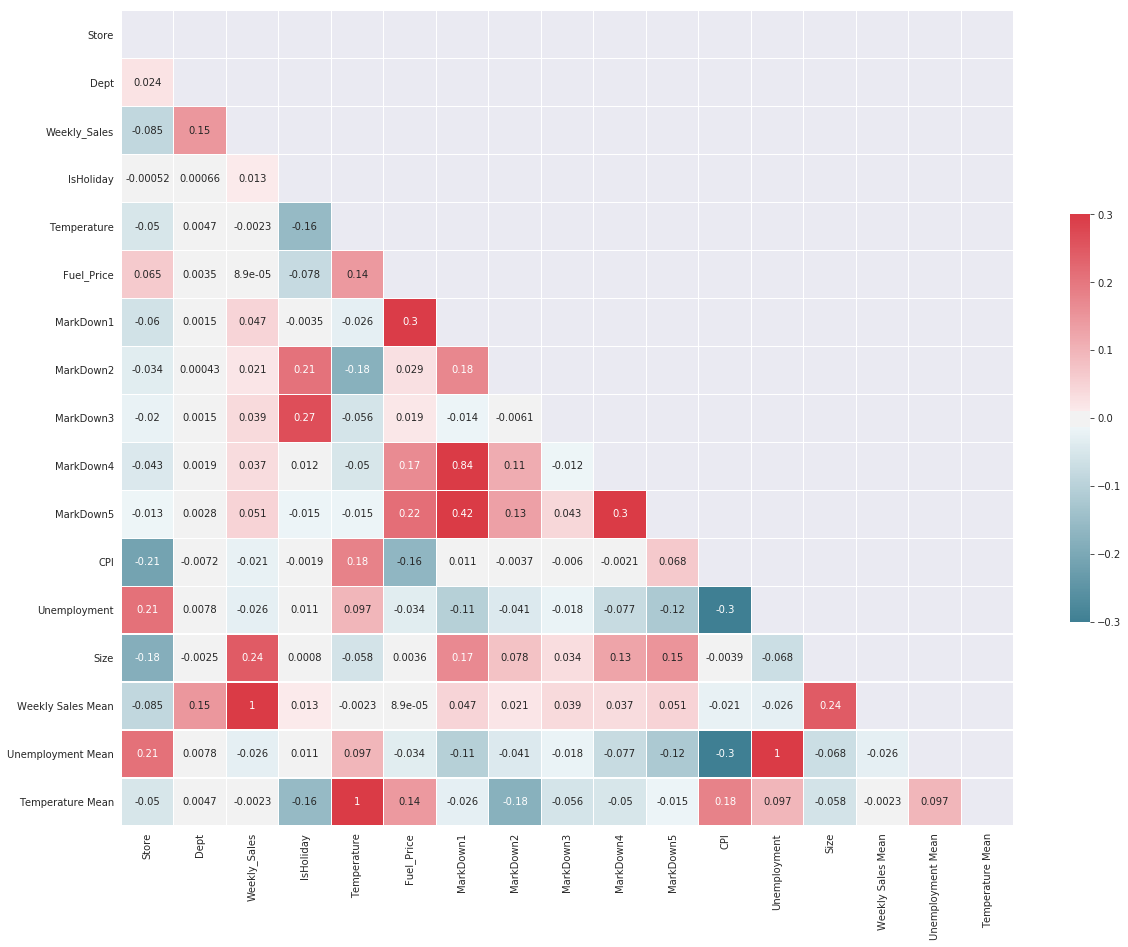

In [0]:
sns.set_style('dark')
corr = data.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f,ax = plt.subplots(figsize=(20,15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

fig = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            linewidths=.2, cbar_kws={"shrink": .5})

### Logical deductions:
 - If the Fuel Price in the area is less then more customers would travel to the store for shopping purpose, however that has a very less correlation.
 - If there is an inflation, Cost of goods will rise which causes CPI to increase. This will cause a reduction in sales which is obvious. But again, CPI doesn't have much correlation.
 - For a lesser store numbers, the weekly sales are higher. Unemployment, Temperature is less, Sales are higher. (Not much correlation)

## **Machine Learning Algorithms:**

In [5]:
#Joining the train data with store and features data using inner join.
train = train.merge(features, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')
print(train.shape)

(421570, 17)


In [6]:
# Make one IsHoliday column instead of two.
train = train.drop(['IsHoliday_y'], axis=1)
train = train.rename(columns={'IsHoliday_x':'IsHoliday'})
print('Train columns:\n', train.columns)

Train columns:
 Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size'],
      dtype='object')


In [0]:
# Converting Date to datetime
train['Date'] = pd.to_datetime(train['Date'])

# Extract date features
train['Date_dayofweek'] =train['Date'].dt.dayofweek
train['Date_month'] =train['Date'].dt.month 
train['Date_year'] =train['Date'].dt.year
train['Date_day'] =train['Date'].dt.day 

### **Numeric Encoding:**

In [0]:
train_data = [train]

# Converting Categorical Variable 'Type' into Numerical Variables.
type_mapping = {"A": 1, "B": 2, "C": 3}
for dataset in train_data:
    dataset['Type'] = dataset['Type'].map(type_mapping)

# Converting Categorical Variable 'IsHoliday' into Numerical Variables.
type_mapping = {False: 0, True: 1}
for dataset in train_data:
    dataset['IsHoliday'] = dataset['IsHoliday'].map(type_mapping)

### **New holidays -  Super Bowl, Labor Day, Thanksgiving and Christmas**

In [0]:
# Kaggle has provided some dates to be allocated to special holidays. We have taken the special holidays into account and marked them as holidays.
train['Super_Bowl'] = np.where((train['Date'] == datetime(2010,2,10)) | (train['Date'] == datetime(2011,2,11)) | 
                               (train['Date'] == datetime(2012,2,10)) | (train['Date'] == datetime(2013,2,8)), 1, 0)
train['Labor_day'] = np.where((train['Date'] == datetime(2010,9,10)) | (train['Date'] == datetime(2011,9,9)) | 
                              (train['Date'] == datetime(2012,9,7)) | (train['Date'] == datetime(2013,9,6)), 1, 0)
train['Thanksgiving'] = np.where((train['Date']==datetime(2010, 11, 26)) | (train['Date']==datetime(2011, 11, 25)) | 
                                 (train['Date']==datetime(2012, 11, 23)) | (train['Date']==datetime(2013, 11, 29)),1,0)
train['Christmas'] = np.where((train['Date']==datetime(2010, 12, 31)) | (train['Date']==datetime(2011, 12, 30)) | 
                              (train['Date']==datetime(2012, 12, 28)) | (train['Date']==datetime(2013, 12, 27)),1,0)

In [10]:
print('Train holidays:\n')
print ('Christmas:\n', train.Christmas.value_counts(),'\n')
print ('Super Bowl:\n', train.Super_Bowl.value_counts(),'\n')
print ('Thanksgiving:\n', train.Thanksgiving.value_counts(),'\n')
print ('Labor Day:\n', train.Labor_day.value_counts(),'\n')

Train holidays:

Christmas:
 0    415624
1      5946
Name: Christmas, dtype: int64 

Super Bowl:
 0    415631
1      5939
Name: Super_Bowl, dtype: int64 

Thanksgiving:
 0    415611
1      5959
Name: Thanksgiving, dtype: int64 

Labor Day:
 0    412709
1      8861
Name: Labor_day, dtype: int64 



In [0]:
# Since we have Imputed IsHoliday according to Extra holidays..These extra holiday variable has redundant.
# Droping the Extra holiday variables because its redundant.
dp = ['Super_Bowl','Labor_day','Thanksgiving','Christmas']
train.drop(dp, axis=1, inplace=True)

In [12]:
train = train.fillna(0)
#Remove negative values as sales cannot be negative.
train = train[train['Weekly_Sales'] >= 0]
train.shape

(420285, 20)

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420285 entries, 0 to 421569
Data columns (total 20 columns):
Store             420285 non-null int64
Dept              420285 non-null int64
Date              420285 non-null datetime64[ns]
Weekly_Sales      420285 non-null float64
IsHoliday         420285 non-null int64
Temperature       420285 non-null float64
Fuel_Price        420285 non-null float64
MarkDown1         420285 non-null float64
MarkDown2         420285 non-null float64
MarkDown3         420285 non-null float64
MarkDown4         420285 non-null float64
MarkDown5         420285 non-null float64
CPI               420285 non-null float64
Unemployment      420285 non-null float64
Type              420285 non-null int64
Size              420285 non-null int64
Date_dayofweek    420285 non-null int64
Date_month        420285 non-null int64
Date_year         420285 non-null int64
Date_day          420285 non-null int64
dtypes: datetime64[ns](1), float64(10), int64(9)
memory usag

### **Remove unnecessary columns:**

In [15]:
# Not so important features.
features_drop=['Unemployment','CPI','MarkDown5']
train=train.drop(features_drop, axis=1)

print('Final train shape:', train.shape)
train.head(2)

Final train shape: (420285, 17)


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,Type,Size,Date_dayofweek,Date_month,Date_year,Date_day
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,1,151315,4,2,2010,5
1,1,2,2010-02-05,50605.27,0,42.31,2.572,0.0,0.0,0.0,0.0,1,151315,4,2,2010,5


### **Train-Test splitting:**

In [0]:
train = train.sort_values(by='Date', ascending=True) # Sorting the data in increasing order of Date and then splitting.
y = train['Weekly_Sales']
X = train.drop(['Weekly_Sales'], axis=1) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # Train:Test = 70:30 splitting.
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3) #Train:CV = 70:30 splitting.

In [0]:
# Remove Date column as it does not allow the models to fit on the data. 
X_train = X_train.drop(['Date'], axis=1)
X_cv = X_cv.drop(['Date'], axis=1)
X_test = X_test.drop(['Date'], axis=1)

In [19]:
# Final shapes.
print('Train:', X_train.shape, y_train.shape)
print('CV:', X_cv.shape, y_cv.shape)
print('Test', X_test.shape, y_test.shape)

Train: (205939, 15) (205939,)
CV: (88260, 15) (88260,)
Test (126086, 15) (126086,)


In [0]:
"""Define Performance metric - Weighted Mean Absolute Error (WMAE)"""

def wmae_train(test, pred): # WMAE for train
  weights = X_train['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error  

def wmae_cv(test, pred): # WMAE for CV
  weights = X_cv['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error

def wmae_test(test, pred): # WMAE for test
  weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error

## **Apply Regression Models:**

Here we will use below regression models for Weekly Sales Prediction.
  - Linear Reagression
  - K Nearest Neighbors Regression
  - Ridge Regression
  - Lasso Regression
  - Decision Tree Regression
  - Random Forest Regression
  - ExtraTrees Regression
  - XGBoost Regression

In every model below steps will be performed.
  - Define the parameters that each library takes.
  - Fit the model on training data.
  - Hyperparameter-tune the parameters using GridSearch/RandomSearch technique.
  - Retrain the model on tuned paramteres.
  - Predict the test values.
  - Get the accuracy using score function.


### **1. Linear Regression:**

In [0]:
# Define list of empty train error and cv error.
error_cv_lr = []
error_train_lr = []
fit_intercept = [True,False]
normalize = [True,False]
lr_hyperparams = []

"""Calculating train and CV errors for Fit Intercept and Normalize parameters."""

for i in fit_intercept:
    for j in normalize:
        lr = LinearRegression(fit_intercept=i, normalize=j) # Apply Linear Regression.
        lr.fit(X_train, y_train) # Fit the model.
        y_pred_cv_lr = lr.predict(X_cv) # Predict CV data.
        y_pred_train_lr = lr.predict(X_train) # Predict Train data.
        error_cv_lr.append(wmae_cv(y_cv, y_pred_cv_lr)) # Get CV error.
        error_train_lr.append(wmae_train(y_train, y_pred_train_lr)) # Get Train error.
        lr_hyperparams.append({'Fit Intercept':i, 'Normalize':j}) # Hyperparameters.

In [0]:
"""Making dataframe containing values of hyper parameters with train and cv errors for the purpose of creating heatmaps."""

lr_dataframe = pd.DataFrame(lr_hyperparams)
lr_dataframe['Train Error'] = error_train_lr
lr_dataframe['CV Error'] = error_cv_lr
lr_dataframe.sort_values(by=['CV Error'], ascending=True)
lr_dataframe

,Fit Intercept,Normalize,Train Error,CV Error
0,True,True,14716.842027,14818.20284
1,True,False,14716.842027,14818.20284
2,False,True,14716.842027,14818.20284
3,False,False,14716.842027,14818.20284


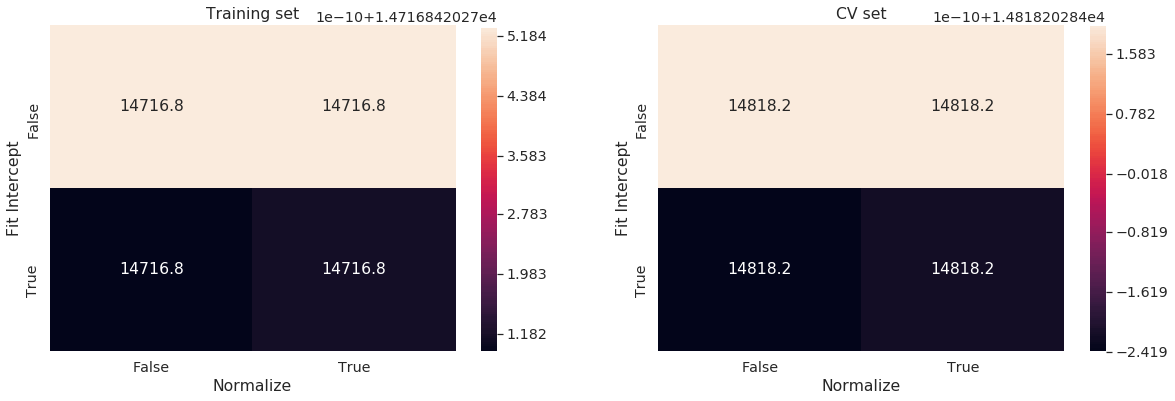

In [0]:
"""Creating heatmaps for Train loss and CV loss."""

sns.set(font_scale=1.3)
train_lr = pd.pivot_table(lr_dataframe,'Train Error','Fit Intercept','Normalize') # Train Pivot table
cv_lr = pd.pivot_table(lr_dataframe, 'CV Error','Fit Intercept','Normalize') # CV Pivot table.
fig, ax = plt.subplots(1,2, figsize=(20,6))
ax_train = sns.heatmap(train_lr, annot=True, fmt='4g', ax=ax[0]) # Train heatmap.
ax_cv = sns.heatmap(cv_lr, annot=True, fmt='4g', ax=ax[1]) # CV heatmap.

bottom_train, top_train = ax_train.get_ylim()
ax_train.set_ylim(bottom_train + 0.5, top_train - 0.5)

bottom_cv, top_cv = ax_cv.get_ylim()
ax_cv.set_ylim(bottom_cv + 0.5, top_cv - 0.5)

ax[0].set_title('Training set')
ax[1].set_title('CV set')
plt.show()

  - Observation: Taking fit_interceot=True and normalize=True as error values are same everywhere.
  

In [0]:
"""Calculate Prediction and WMAE score."""

model_linear_reg = LinearRegression(fit_intercept=True,normalize=True).fit(X_train,y_train) # Fit the model.
y_pred = model_linear_reg.predict(X_test) # Predict test data.
print('Weighted Mean Absolute Error (WMAE) for Linear Regression:', wmae_test(y_test, y_pred)) # Calculate WMAE score.

Weighted Mean Absolute Error (WMAE) for Linear Regression: 14904.668504832987


### **2. KNN Regression:**

In [0]:
# Define empty train and CV error lists and list of hyper parameter values. 
error_cv = []
error_train = []

for i in range(3,22,2): # Loop over number of nearest neighbors (K) values [3,5,7,9,11,13,15,17,19,21].
    knn = KNeighborsRegressor(n_neighbors=i) # Apply KNN Regressor.
    knn.fit(X_train, y_train) # Fit the model.
    y_pred_cv= knn.predict(X_cv) # Predict CV data.
    y_pred_train= knn.predict(X_train) # Predict Train data.
    error_cv.append(wmae_cv(y_cv, y_pred_cv)) # Get CV error.
    error_train.append(wmae_train(y_train, y_pred_train)) # Get Train error.

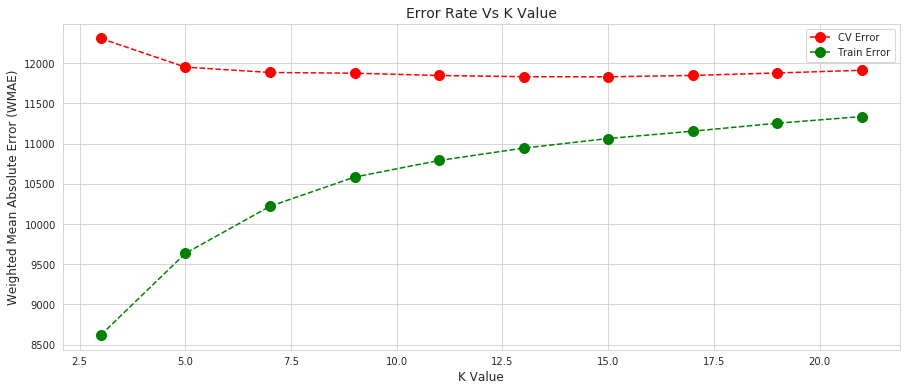

In [0]:
"""Plot Train error and CV error against number of nearest neighbors (K) values to select best hyper parameter."""

plt.figure(figsize=(15, 6))
plt.plot(range(3,22,2), error_cv, color='red', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10, label='CV Error')
plt.plot(range(3,22,2), error_train, color='green', linestyle='dashed', marker='o',markerfacecolor='green', markersize=10, label='Train Error')
plt.legend(loc='best')
plt.title('Error Rate Vs K Value', fontsize=14)
plt.xlabel('K Value',fontsize=12)
plt.ylabel('Weighted Mean Absolute Error (WMAE)', fontsize=12)
plt.show()

 - Observation: Best value of hyperparameter K is 11 as both training and CV error scores are low at K=11.

In [0]:
"""Calculate Prediction and WMAE score."""

model_knn = KNeighborsRegressor(n_neighbors=11).fit(X_train, y_train) # Fit the model with best K value.
y_pred_test = model_knn.predict(X_test) # Predict test data.
print('Weighted Mean Absolute Error (WMAE) for KNN Regression:', wmae_test(y_test, y_pred_test)) # Calculate WMAE score.

Weighted Mean Absolute Error (WMAE) for KNN Regression: 11887.99500397462


### **3. Ridge Regression:**

In [0]:
# Define the empty train and CV error lists and list of hyper parameter values.
error_cv_ridge = []
error_train_ridge = []
alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,20,50,100,200,500,1000]

"""Calculating train and cv errors for alpha values."""

for i in alpha:# Loop over alpha.
  ridge = Ridge(alpha=i) # Apply Ridge Regressor.
  ridge.fit(X_train, y_train) # Fit the mdoel.
  y_pred_cv_ridge = ridge.predict(X_cv) # Predict CV data.
  y_pred_train_ridge = ridge.predict(X_train) # Predict Train data.
  error_cv_ridge.append(wmae_cv(y_cv, y_pred_cv_ridge)) # Calculate CV error.
  error_train_ridge.append(wmae_train(y_train, y_pred_train_ridge)) # Calculate Train error.

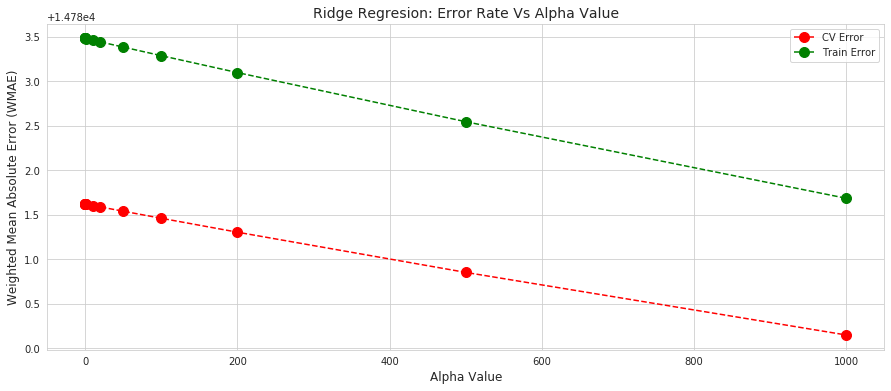

In [0]:
"""Plot Train error and CV error against alpha values to select best hyper parameter."""

plt.figure(figsize=(15, 6))
plt.plot(alpha, error_cv_ridge, color='red', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10, label='CV Error')
plt.plot(alpha, error_train_ridge, color='green', linestyle='dashed', marker='o',markerfacecolor='green', markersize=10, label='Train Error')
plt.legend(loc='best')
plt.title('Ridge Regresion: Error Rate Vs Alpha Value', fontsize=14)
plt.xlabel('Alpha Value',fontsize=12)
plt.ylabel('Weighted Mean Absolute Error (WMAE)', fontsize=12)
plt.show()

  - Observation: Alpha Value can be taken as 1000 as training error and CV error are at lowest at alpha=1000

In [0]:
"""Calculate Prediction and WMAE score."""

model_ridge = Ridge(alpha=1000).fit(X_train, y_train) # Fit the model with best alpha value.
y_pred = model_ridge.predict(X_test) # Predict test data.
print('Weighted Mean Absolute Error (WMAE) for Ridge Regression:', wmae_test(y_test, y_pred)) # Get WMAE score.

Weighted Mean Absolute Error (WMAE) for Ridge Regression: 14824.52315060717


### **4. Lasso Regression:**

In [0]:
# Define empty train and cv error list and list of hyper parameter values.
error_cv_lasso = []
error_train_lasso = []
alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,20,50,100,200,500,1000]

"""Calculating train and cv errors for alpha values."""

for i in alpha: # Loop over alpha
  lasso = Lasso(alpha=i) # Apply Lasso Regresor.
  lasso.fit(X_train, y_train) # Fit the model.
  y_pred_cv_lasso = lasso.predict(X_cv) # Predict CV data.
  y_pred_train_lasso = lasso.predict(X_train) # Predict Train data.
  error_cv_lasso.append(wmae_cv(y_cv, y_pred_cv_lasso)) # Get CV error.
  error_train_lasso.append(wmae_train(y_train, y_pred_train_lasso)) # Get Train error.

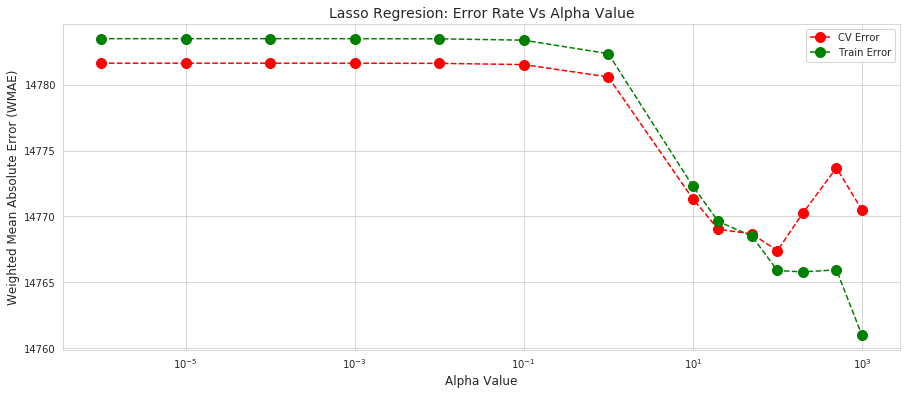

In [0]:
"""Plot Train error and CV error against alpha values to select best hyper parameter."""

plt.figure(figsize=(15, 6))
plt.plot(alpha, error_cv_lasso, color='red', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10, label='CV Error')
plt.plot(alpha, error_train_lasso, color='green', linestyle='dashed', marker='o',markerfacecolor='green', markersize=10, label='Train Error')
plt.legend(loc='best')
plt.xscale('log')
plt.title('Lasso Regresion: Error Rate Vs Alpha Value', fontsize=14)
plt.xlabel('Alpha Value',fontsize=12)
plt.ylabel('Weighted Mean Absolute Error (WMAE)', fontsize=12)
plt.show()

  - Observation: At alpha=100, both training and CV errors are low.

In [0]:
"""Calculate Prediction and WMAE score."""

model_lasso = Lasso(alpha=100).fit(X_train, y_train) # Fit the model with best alpha value.
y_pred = model_lasso.predict(X_test) # Predict test data.
print('Weighted Mean Absolute Error (WMAE) for Lasso Regression:', wmae_test(y_test, y_pred)) # Calculate WMAE score.

Weighted Mean Absolute Error (WMAE) for Lasso Regression: 14810.891612655665


### **5. Decision Tree Regression:**

In [0]:
# Define the list of errors and list of hyper parameters.
error_cv_dt = []
error_train_dt = []
max_depth = [1,5,10,15,20,25,30,35]
min_samples_leaf = [1,2,3,4,5,6,7,8]
dt_hyperparams = []

"""Calculating train and CV errors for maximum depth and minimum samples leaf parameters."""

for i in max_depth: # Loop over max_depth.
    for j in min_samples_leaf: # Loop over min_samples_leaf.
        dt = DecisionTreeRegressor(max_depth=i, min_samples_leaf=j) # Apply Decision Tree Regressor.
        dt.fit(X_train, y_train) # Fit the model.
        y_pred_cv_dt = dt.predict(X_cv) # Predict CV data.
        y_pred_train_dt = dt.predict(X_train) # Predict Train data.
        error_cv_dt.append(wmae_cv(y_cv, y_pred_cv_dt)) # Calculate CV error.
        error_train_dt.append(wmae_train(y_train, y_pred_train_dt)) # Calculate Train error.
        dt_hyperparams.append({'depth':i, 'leaf':j}) # Get the list of hyper parameters.

In [33]:
"""Making dataframe containing values of hyper parameters with train and cv errors for the purpose of creating heatmaps."""

dt_dataframe = pd.DataFrame(dt_hyperparams)
dt_dataframe['train error'] = error_train_dt
dt_dataframe['cv error'] = error_cv_dt
dt_dataframe.sort_values(by=['cv error'], ascending=True)
dt_dataframe.head()

,depth,leaf,train error,cv error
0,1,1,14295.220846,14253.661166
1,1,2,14295.220846,14253.661166
2,1,3,14295.220846,14253.661166
3,1,4,14295.220846,14253.661166
4,1,5,14295.220846,14253.661166


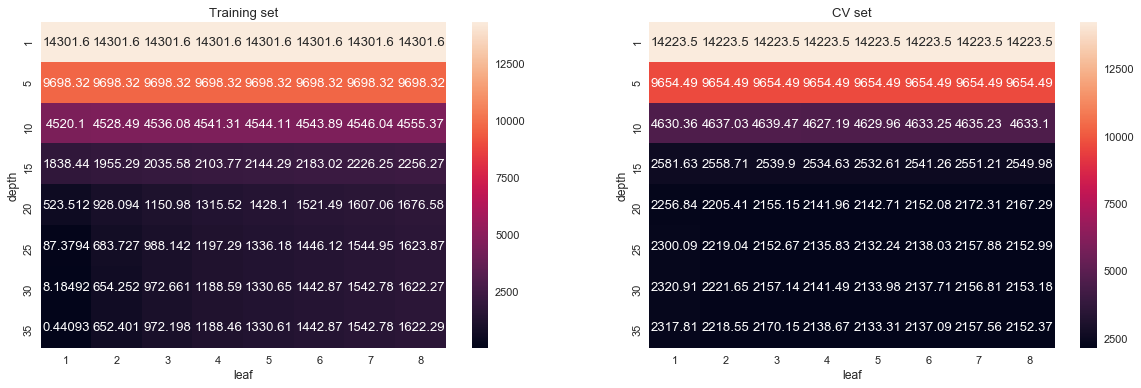

In [0]:
"""Creating heatmaps for Train loss and CV loss."""

sns.set(font_scale=1.1,)
train_dt = pd.pivot_table(dt_dataframe ,'train error','depth','leaf') # Pivot table for train.
cv_dt = pd.pivot_table(dt_dataframe , 'cv error','depth','leaf') # Pivot table for CV.
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(a, annot=True, fmt='2g', ax=ax[0]) # Train heatmap.
sns.heatmap(b, annot=True, fmt='4g', ax=ax[1]) # CV heatmap.
ax[0].set_title('Training set')
ax[1].set_title('CV set')
plt.show()

  - Observation: The Training loss and CV loss are least for maximum depth of 25 and minimum samples leaf of 5.

In [0]:
"""Calculate Prediction and WMAE score."""

model_dt = DecisionTreeRegressor(max_depth=25, min_samples_leaf=5).fit(X_train, y_train) # Fit the model with best hyper parameter values.
y_pred = model_dt.predict(X_test) # Predict the test data.
print('Weighted Mean Absolute Error (WMAE) for Decision Tree Regression:', wmae_test(y_test, y_pred)) # Get WMAE score.

Weighted Mean Absolute Error (WMAE) for Decision Tree Regression: 2134.170706334696


### **6. Random Forest Regression:**

In [0]:
# Define the list of errors and list of hyper parameters.
error_cv_rf = []
error_train_rf = []
max_depth = [1,5,10,15,20,25,30,35]
n_estimators = [10,20,30,40,50,60,70,80]
rf_hyperparams = []

"""Calculating train and CV errors for maximum depth and number of estimators parameters."""

for i in max_depth: # Loop over max_depth.
    for j in n_estimators: # Loop over n_estimators. 
        rf = RandomForestRegressor(max_depth=i, n_estimators=j) # Apply Random Forest Regressor.
        rf.fit(X_train, y_train) # Fit the model.
        y_pred_cv_rf = rf.predict(X_cv) # Predict CV data.
        y_pred_train_rf = rf.predict(X_train) # Predict Train data.
        error_cv_rf.append(wmae_cv(y_cv, y_pred_cv_rf)) # Get CV error.
        error_train_rf.append(wmae_train(y_train, y_pred_train_rf)) # Get Train error.
        rf_hyperparams.append({'Maximum Depth':i, 'No. of Estimators':j}) # Get list of hyper parameter values.

In [31]:
"""Making dataframe containing values of hyper parameters with train and cv errors for the purpose of creating heatmaps."""

rf_dataframe = pd.DataFrame(rf_hyperparams)
rf_dataframe['Train Error']=error_train_rf
rf_dataframe['CV Error']=error_cv_rf
rf_dataframe.sort_values(by=['CV Error'], ascending=True)
rf_dataframe.head()

,Maximum Depth,No. of Estimators,Train Error,CV Error
0,1,10,14290.268001,14248.863713
1,1,20,14294.920050,14253.534288
2,1,30,14294.288770,14252.678967
3,1,40,14292.181606,14250.828999
4,1,50,14295.126077,14253.739526


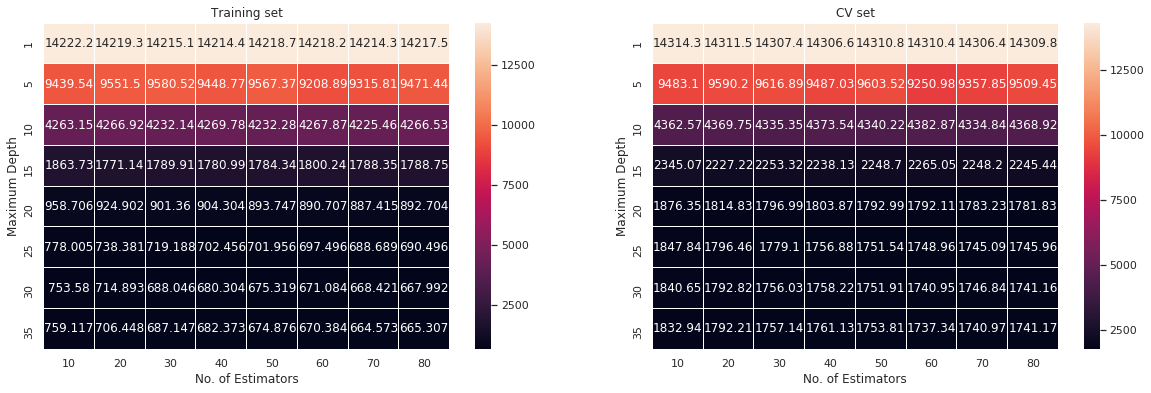

In [0]:
"""Creating heatmaps for Train loss and CV loss."""

sns.set(font_scale=1.0)
train_rf = pd.pivot_table(rf_dataframe,'Train Error','Maximum Depth','No. of Estimators') # Pivot table of Train data.
cv_rf = pd.pivot_table(rf_dataframe, 'CV Error','Maximum Depth','No. of Estimators') # Pivot table of CV data.
fig, ax = plt.subplots(1,2, figsize=(20,6))
ax_train = sns.heatmap(train_rf, annot=True, fmt='2g', ax=ax[0], linewidths=0.01)
ax_cv = sns.heatmap(cv_rf, annot=True, fmt='4g', ax=ax[1], linewidths=0.01)

bottom_train, top_train = ax_train.get_ylim()
ax_train.set_ylim(bottom_train + 0.5, top_train - 0.5)

bottom_cv, top_cv = ax_cv.get_ylim()
ax_cv.set_ylim(bottom_cv + 0.5, top_cv - 0.5)

ax[0].set_title('Training set')
ax[1].set_title('CV set')
plt.show()

  - Observation: The training loss and CV loss are least for Maximum Depth of 35 and Number of Estimators of 80 .

In [0]:
"""Calculate Prediction and  WMAE score."""

model_rf = RandomForestRegressor(max_depth= 35, n_estimators=80).fit(X_train, y_train) # Fit the model with best hyper parameter values.
y_pred = model_rf.predict(X_test) # Predict the test data.
print('Weighted Mean Absolute Error (WMAE) for Random Forest Regression:', wmae_test(y_test, y_pred)) # Get WMAE score.

Weighted Mean Absolute Error (WMAE) for Random Forest Regression: 1785.20925311315


### **7. ExtraTrees Regression:**

In [0]:
# Define list of errors and list of hyper parameters.
error_cv_et = []
error_train_et = []
max_depth = [1,5,10,15,20,25,30,35]
min_samples_leaf = [1,2,3,4,5,6,7,8]
extratrees_hyperparams = []

"""Calculating train and CV errors for maximum depth and minimum samples leaf parameters."""

for i in max_depth: # Loop over max_depth
    for j in min_samples_leaf: # Loop over min_samples_leaf
        et = ExtraTreesRegressor(max_depth=i, min_samples_leaf=j) # Apply ExtraTrees Regressor.
        et.fit(X_train, y_train) # Fit the model.
        y_pred_cv_et = et.predict(X_cv) # Predict CV data.
        y_pred_train_et = et.predict(X_train) # Predict Train data.
        error_cv_et.append(wmae_cv(y_cv, y_pred_cv_et)) # Get CV Error.
        error_train_et.append(wmae_train(y_train, y_pred_train_et)) # Get Train Error.
        extratrees_hyperparams.append({'depth':i, 'leaf':j}) # Get the list of hyper parameters.

In [29]:
"""Making dataframe containing values of hyper parameters with train and cv errors for the purpose of creating heatmaps."""

extratrees_datafarame = pd.DataFrame(extratrees_hyperparams)
extratrees_datafarame['train error']=error_train_et
extratrees_datafarame['cv error']=error_cv_et
extratrees_datafarame.sort_values(by=['cv error'], ascending=True)
extratrees_datafarame.head()

,depth,leaf,train error,cv error
0,1,1,14552.503570,14552.907145
1,1,2,14836.067518,14857.540053
2,1,3,14746.130260,14758.478697
3,1,4,14728.868933,14734.615476
4,1,5,14705.759285,14718.184164


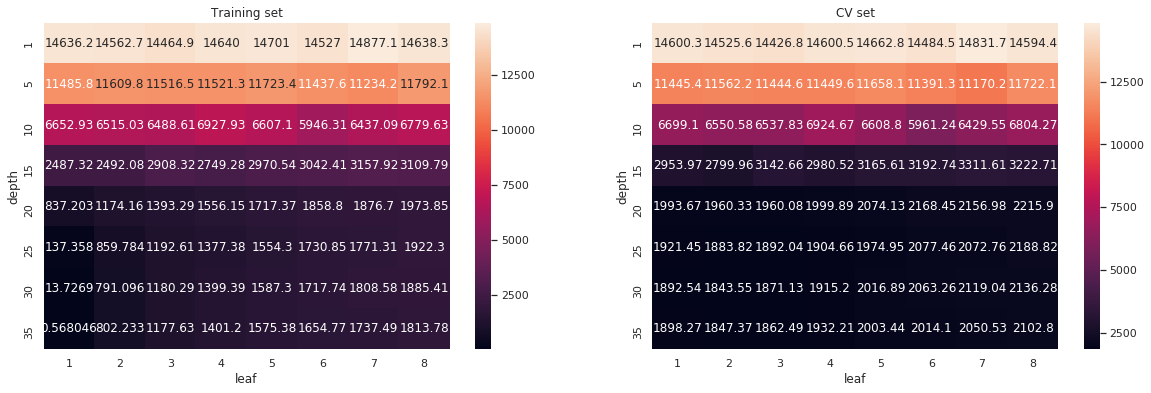

In [0]:
"""Creating heatmaps for Train loss and CV loss.""""

sns.set(font_scale=1.0)
train_et = pd.pivot_table(extratrees_datafarame,'train error','depth','leaf') # Train Pivot table.
cv_et = pd.pivot_table(extratrees_datafarame, 'cv error','depth','leaf') # CV Pivot table.
fig, ax = plt.subplots(1,2, figsize=(20,6))
ax_train = sns.heatmap(train_et, annot=True, fmt='2g', ax=ax[0]) # Train heatmap.
ax_cv = sns.heatmap(cv_et, annot=True, fmt='4g', ax=ax[1]) # CV heatmap.

bottom_train, top_train = ax_train.get_ylim() 
ax_train.set_ylim(bottom_train + 0.5, top_train - 0.5) 

bottom_cv, top_cv = ax_cv.get_ylim()
ax_cv.set_ylim(bottom_cv + 0.5, top_cv - 0.5)

ax[0].set_title('Training set')
ax[1].set_title('CV set')
plt.show()

  - Observation:  The Training loss and CV loss are least for maximum depth of 30 and minimum samples leaf of 2.

In [0]:
### **8. XGBoost Regression:**"""Calculate Prediction and WMAE score."""

model_ExtraTrees = ExtraTreesRegressor(max_depth=30, min_samples_leaf=2).fit(X_train,y_train) # Fit the model with best hyper parameter values.
y_pred = model_ExtraTrees.predict(X_test) # Predict test data.
print('Weighted Mean Absolute Error (WMAE) for ExtraTrees Regression:', wmae_test(y_test, y_pred)) # Get WMAE score.

Weighted Mean Absolute Error (WMAE) for ExtraTrees Regression: 1986.2937404530494


### **8. XGBoost Regression:**

In [ ]:
# Define list of empty errors and list of hyper parameters.
error_cv_xgb = []
error_train_xgb = []
max_depth = [1,5,10,15,20,25,30,35]
n_estimators = [10,20,30,40,50,60,70,80]
xgb_hyperparams=[]

"""Calculating train and CV errors for maximum depth and number of estimators parameters."""

for i in max_depth: #Looping over max_depth
    for j in n_estimators: #Looping over n_estimators.
        xgb = XGBRegressor(max_depth=i, n_estimators=j, objective='reg:squarederror') # objective is included to avoid XGBoost warnings.
        xgb.fit(X_train, y_train) # Fit the model.
        y_pred_cv_xgb = xgb.predict(X_cv) # Predict cv data.
        y_pred_train_xgb = xgb.predict(X_train) # Predict train data.
        error_cv_xgb.append(wmae_cv(y_cv, y_pred_cv_xgb)) # Calculate CV error.
        error_train_xgb.append(wmae_train(y_train, y_pred_train_xgb)) # Calculate Train error.
        xgb_hyperparams.append({'Maximum Depth':i, 'No. of Estimators':j}) # Append xgb_hyperparams.

In [ ]:
"""Making dataframe containing values of hyper parameters with train and cv errors for the purpose of creating heatmaps."""

xgb_dataframe = pd.DataFrame(xgb_hyperparams)
xgb_dataframe['Train Error'] = error_train_xgb
xgb_dataframe['CV Error'] = error_cv_xgb
xgb_dataframe.sort_values(by=['CV Error'], ascending=True)
xgb_dataframe.head()

In [ ]:
"""Creating heatmaps for Train loss and CV loss."""

sns.set(font_scale=1.0)
train_xgb = pd.pivot_table(xgb_dataframe,'Train Error','Maximum Depth','No. of Estimators') # Pivot table for train.
cv_xgb = pd.pivot_table(xgb_dataframe, 'CV Error','Maximum Depth','No. of Estimators') # Pivot table for cv.
fig, ax = plt.subplots(1,2, figsize=(20,6))
ax_train = sns.heatmap(train_xgb, annot=True, fmt='2g', ax=ax[0]) # Train heatmap
ax_cv = sns.heatmap(cv_xgb, annot=True, fmt='2g', ax=ax[1]) # CV heatmap.

bottom_train, top_train = ax_train.get_ylim() 
ax_train.set_ylim(bottom_train + 0.5, top_train - 0.5) 

bottom_cv, top_cv = ax_cv.get_ylim()
ax_cv.set_ylim(bottom_cv + 0.5, top_cv - 0.5)

ax[0].set_title('Training set')
ax[1].set_title('CV set')
plt.show()

In [ ]:
"""Calculate Prediction and WMAE score."""

model_xgb = XGBRegressor(n_estimators=20, max_depth=15, objective='reg:squarederror').fit(X_train,y_train) # Fit the model with best hyper parameter values.
y_pred = model_xgb.predict(X_test) # Predict test data.
print('Weighted Mean Absolute Error (WMAE) for XGBoost Regression:', wmae_test(y_test, y_pred)) # Calculate WMAE score of test data and predicted data.

## **Result**:

In [34]:
models = pd.DataFrame({
    'Model Name': ['Linear Regression','KNN Regression','Ridge Regression','Lasso Regression',
              'Decision Tree Regression','Random Forest Regression','ExtraTrees Regression','XGBoost Regession'],
    
    'WMAE Score': ['14904.66', '11887.99', '14824.52', '14810.89', 
                   '2134.17', '1785.20', '1986.29', '2765.22']
    })

Index = pd.Series([1, 2, 3, 4, 5, 6, 7, 8])
models.set_index(Index, inplace=True)
models

,Model Name,WMAE Score
1,Linear Regression,14904.66
2,KNN Regression,11887.99
3,Ridge Regression,14824.52
4,Lasso Regression,14810.89
5,Decision Tree Regression,2134.17
6,Random Forest Regression,1785.20
7,ExtraTrees Regression,1986.29
8,XGBoost Regession,2765.22


**Conclusion: The lowest Weighted mean absolute error (WMAE) score is observed for Random Forest Regression i.e. 1785.20**